# Descrição

O dataset utilizado para análise foi retirado da plataforma [*Kaggle*](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/). 

>This synthetic dataset was crafted to reflect real-world patterns and includes high-anxiety cases to support research in detection and intervention.

Para analisar os dados, optou-se por atacar o problema como um desafio de classificação, onde a label de uma dada instância é o correspondente nível de ansiedade.

# Leitura e análise inicial do dataset

In [353]:
import pandas as pd

In [354]:
df = pd.read_csv('data/data.csv')
df.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [355]:
df.shape

(11000, 19)

In [356]:
df.describe()

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10),Anxiety Level (1-10)
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,40.241727,6.650691,2.942136,286.090000,9.701636,5.856364,90.916000,20.957545,3.080636,2.427818,5.181818,3.929364
std,13.236140,1.227509,1.827825,144.813157,5.689713,2.927202,17.325721,5.160107,1.398877,2.183106,2.895243,2.122533
min,18.000000,2.300000,0.000000,0.000000,0.000000,1.000000,60.000000,12.000000,1.000000,0.000000,1.000000,1.000000
25%,29.000000,5.900000,1.500000,172.000000,5.000000,3.000000,76.000000,17.000000,2.000000,1.000000,3.000000,2.000000
50%,40.000000,6.700000,2.800000,273.000000,10.000000,6.000000,92.000000,21.000000,3.000000,2.000000,5.000000,4.000000
75%,51.000000,7.500000,4.200000,382.000000,15.000000,8.000000,106.000000,25.000000,4.000000,4.000000,8.000000,5.000000
max,64.000000,11.300000,10.100000,599.000000,19.000000,10.000000,119.000000,29.000000,5.000000,12.000000,10.000000,10.000000


In [357]:
# Verifica a quantidade de valores nulos (vazios) em cada coluna
df.isnull().sum()

Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64

In [358]:
# Analisa colunas categoricas
categorical_columns = df.select_dtypes(include=['object', 'str']).columns
for col in categorical_columns:
    print(f'Coluna: {col}')
    print(df[col].value_counts())
    print('\n')

Coluna: Gender
Gender
Female    3730
Male      3657
Other     3613
Name: count, dtype: int64


Coluna: Occupation
Occupation
Musician      892
Artist        888
Student       878
Nurse         861
Chef          858
Doctor        842
Other         840
Freelancer    838
Engineer      833
Scientist     832
Athlete       822
Lawyer        809
Teacher       807
Name: count, dtype: int64


Coluna: Smoking
Smoking
Yes    5779
No     5221
Name: count, dtype: int64


Coluna: Family History of Anxiety
Family History of Anxiety
Yes    5847
No     5153
Name: count, dtype: int64


Coluna: Dizziness
Dizziness
Yes    5672
No     5328
Name: count, dtype: int64


Coluna: Medication
Medication
Yes    5666
No     5334
Name: count, dtype: int64


Coluna: Recent Major Life Event
Recent Major Life Event
Yes    5623
No     5377
Name: count, dtype: int64




A partir das demonstrações acima, é possível perceber que os dados são balanceados e não nulos (algo esperado de um dataset sintético).

# Criando labels

In [359]:
import pandas as pd
df = pd.read_csv('data/data.csv')

Para auxiliar as análises decidiu-se criar 4 níveis de labels:
1. **Pouco ansioso (0), muito ansioso (1)**
   1. Pouco ansioso = níveis 1 e 2
   2. Muito ansioso = níveis 9 e 10
2. **Pouco/médio ansioso (0), médio/muito ansioso (1)**
   1. Pouco/médio ansioso = níveis menores ou iguais a 5
   2. Médio/muito ansioso = níveis maiores que 5
3. **Pouco ansioso (0), ansiedade moderada (1), muito ansioso (2)**
   1. Pouco = níveis 1 e 2
   2. Moderada = níveis 4 a 6
   3. Muito  = níveis 9 e 10
4. **Categorias originais**

In [360]:
df_level_1 = df.loc[(df['Anxiety Level (1-10)'] <= 2) | (df['Anxiety Level (1-10)'] >= 9)]
df_level_1['label'] = df_level_1['Anxiety Level (1-10)'].apply(lambda x: 0 if x <= 2 else 1)
df_level_1.drop(columns=['Anxiety Level (1-10)'], inplace=True)
df_level_1.to_csv('data/data_level_1.csv', index=False)
df_level_1.shape

(3446, 19)

In [361]:
df_level_2 = df.copy()
df_level_2['label'] = df_level_2['Anxiety Level (1-10)'].apply(lambda x: 0 if x <= 5 else 1)
df_level_2.drop(columns=['Anxiety Level (1-10)'], inplace=True)
df_level_2.to_csv('data/data_level_2.csv', index=False)
df_level_2.shape

(11000, 19)

In [362]:
df_level_3 = df.copy()

def map_anxiety_level(x):
    if x <= 2:
        return 0
    elif x >= 4 and x <= 6:
        return 1
    elif x >= 9:
        return 2

df_level_3['label'] = df_level_3['Anxiety Level (1-10)'].apply(map_anxiety_level)
df_level_3 = df_level_3[df_level_3['label'].notnull()]
df_level_3.drop(columns=['Anxiety Level (1-10)'], inplace=True)
df_level_3.to_csv('data/data_level_3.csv', index=False)
df_level_3.shape

(8107, 19)

In [363]:
df_level_4 = df.copy()
df_level_4.rename(columns={'Anxiety Level (1-10)': 'label'}, inplace=True)
df_level_4.to_csv('data/data_level_4.csv', index=False)
df_level_4.shape

(11000, 19)

# Informação mútua & Gráficos de distribuição

Para fazer uma análise da importância das features, optou-se por utilizar o dataset cujas labels identificam extremos: `data_level_1.csv`, onde a label 1 corresponde aos níveis 9 e 10 de ansiedade e a label 0, aos níveis 1 e 2.

In [364]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

In [365]:
df = pd.read_csv('data/data_level_1.csv')

In [366]:
# Colunas cujos valores não possuem um range/valores especificado ou que possuem muitos valores únicos.
# Os valores dessas colunas serão tratados como se fossem contínuos (alguns realmente são).
not_specified_range_columns = [
    'Age',
    'Sleep Hours',
    'Physical Activity (hrs/week)',
    'Caffeine Intake (mg/day)',
    'Alcohol Consumption (drinks/week)',
    'Heart Rate (bpm)',
    'Breathing Rate (breaths/min)'
]

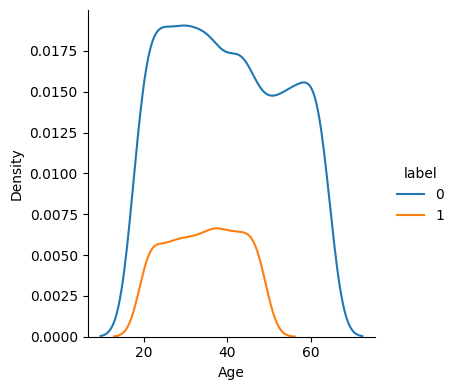

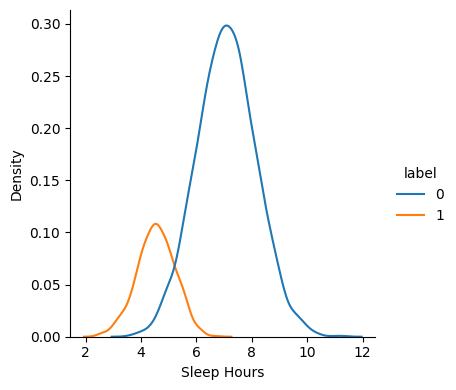

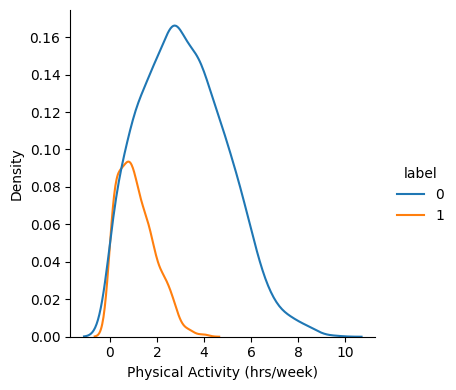

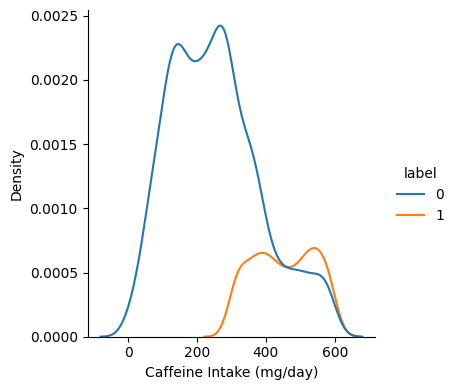

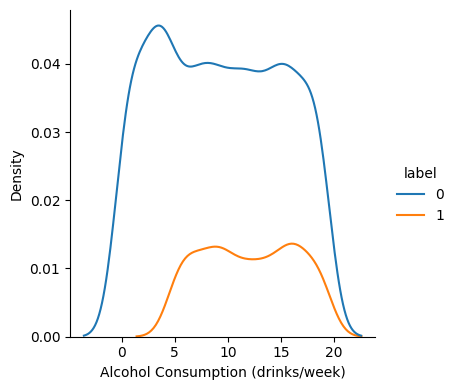

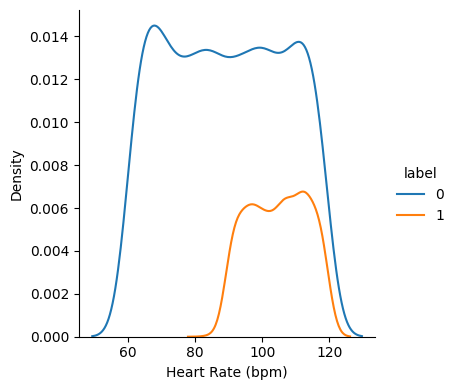

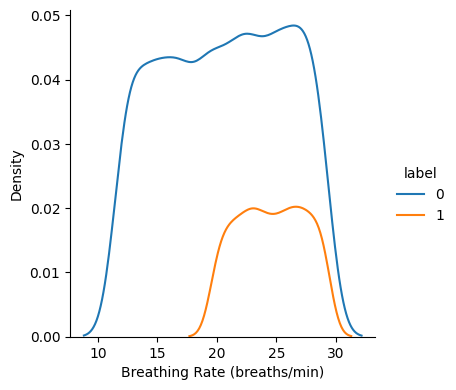

In [367]:
for feature in not_specified_range_columns:
  # sns.relplot(df, y = feature, x = list(range(len(df))), hue = 'label');
  sns.displot(df, x = feature, hue = 'label', kind = 'kde', height=4);

Os gráficos acima demonstram uma relação evidente entre as features e as labels.

A maioria esmagadora dos casos de alta ansiedade se encontra em instâncias com:
1. Idade entre 20 e 50 anos
2. Duração de sono menor que 6 horas
3. 2 ou menos horas de atividade física por semana
4. Consumo de cafeína por dia superior a 300 mg
5. Consumo de álcool superior a 5 drinks por semana
6. Frequência cardíaca superior a 90 bpm
7. Frequência respiratória superior a 20 respirações/min

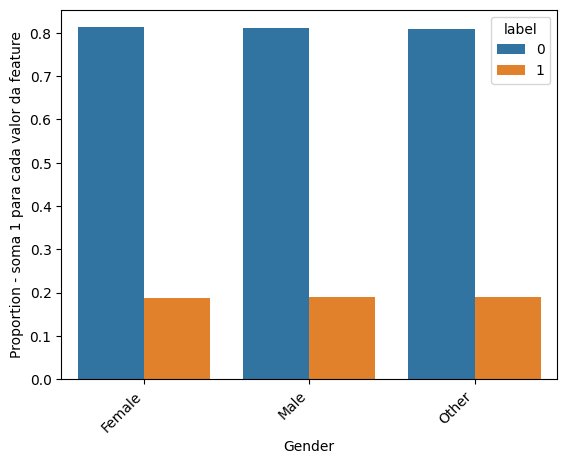

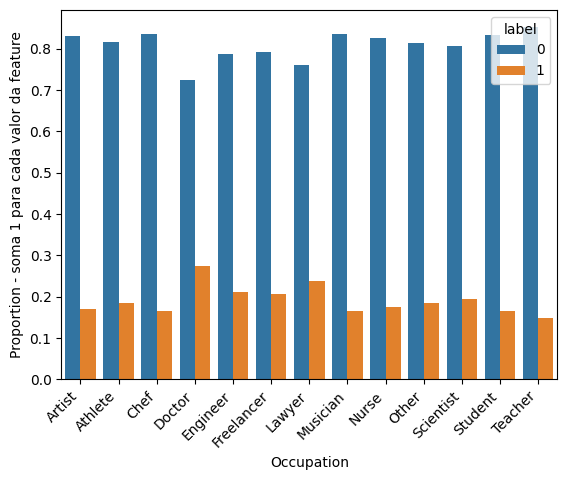

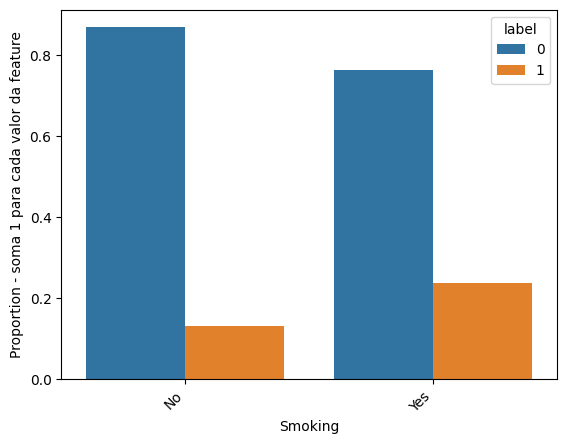

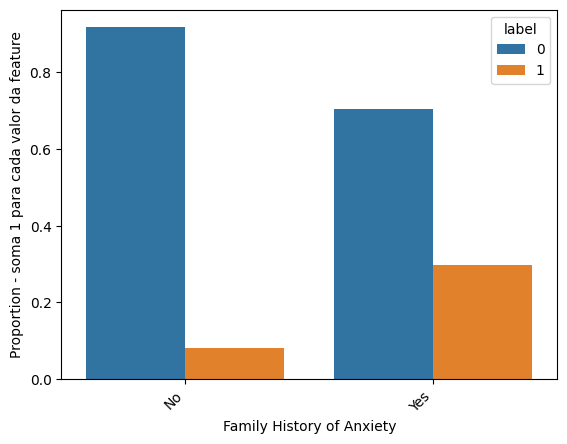

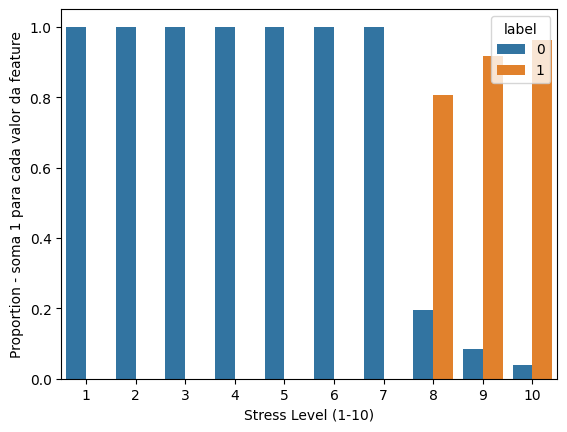

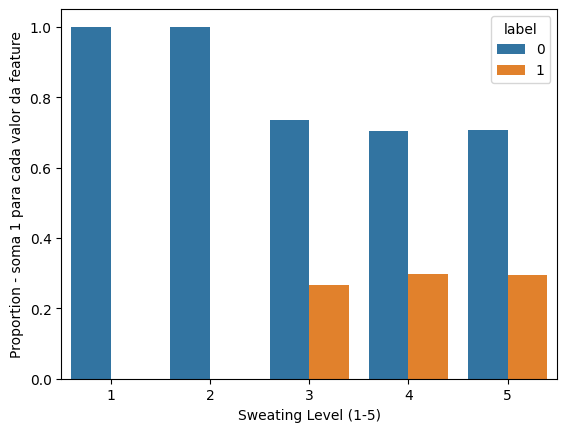

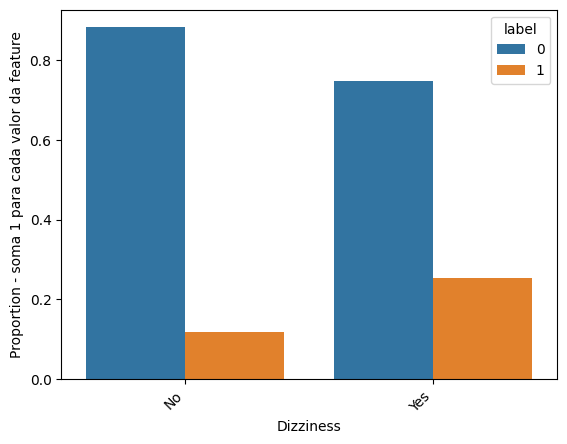

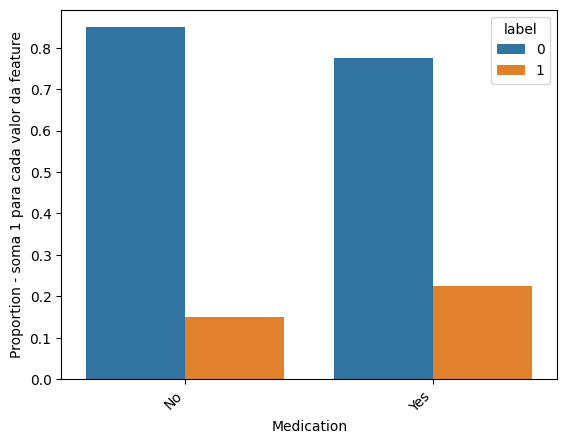

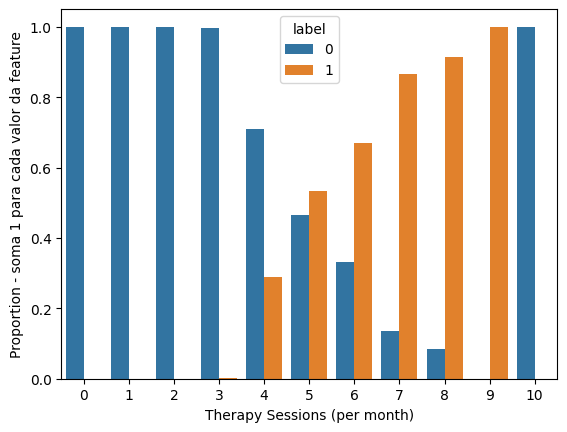

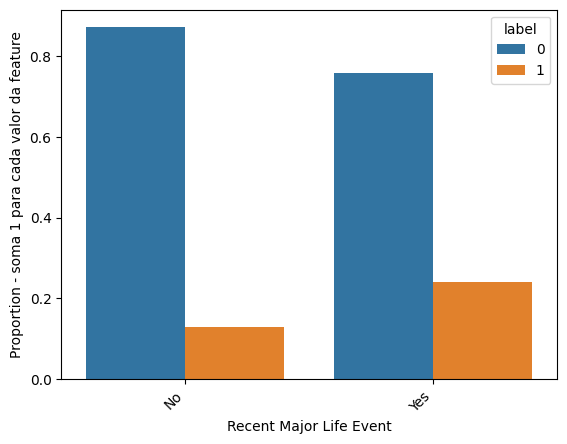

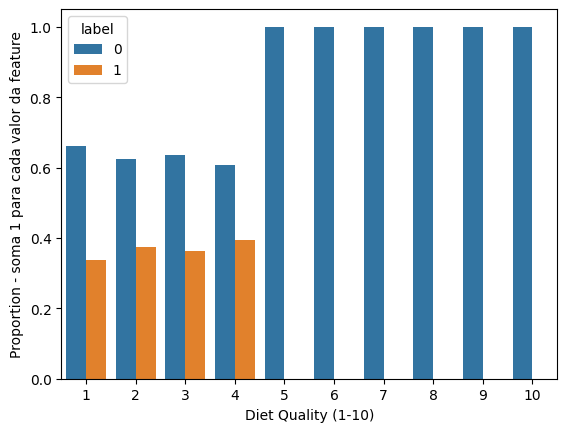

In [368]:
for col in df.columns:
    if col not in not_specified_range_columns + ['label']:
        counts = (
            df
            .groupby([col, 'label'])
            .size()
            .reset_index(name='count')
        )

        counts['prob'] = (
            counts['count']
            / counts.groupby(col)['count'].transform('sum')
        )

        counts.groupby(col)['prob'].sum()

        sns.barplot(
            data=counts,
            x=col,
            y='prob',
            hue='label'
        )
        
        if df[col].dtype in ['object', 'str']:
            plt.xticks(rotation=45, ha='right')
        plt.ylabel('Proportion - soma 1 para cada valor da feature')
        plt.show()

A plotagem acima mostra algumas features com baixíssima relevância (ou seja, as proporções de ansiedade/não ansiedade para valores diferentes da feature são praticamente idênticas), como: gênero, medicação e profissão/ocupação.

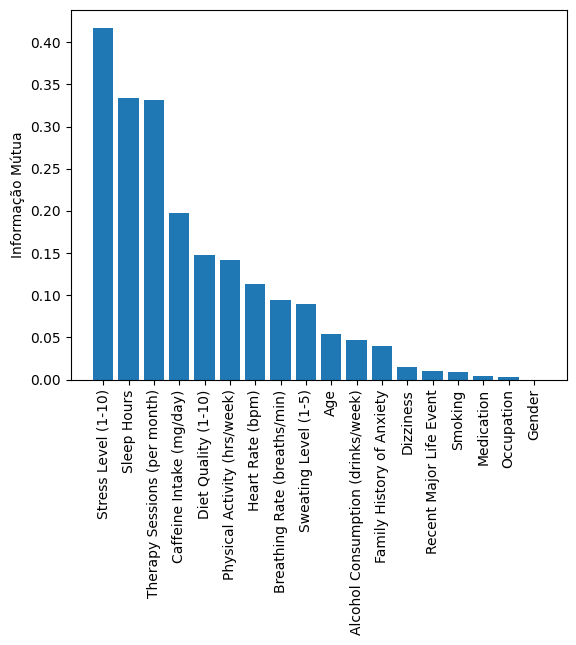

In [369]:
# Faz o encoding das colunas categóricas para o cálculo da informação mútua

non_numeric_columns = df.select_dtypes(include=['object', 'str']).columns
encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded[non_numeric_columns] = encoder.fit_transform(df[non_numeric_columns])

X = np.array(df_encoded.drop('label', axis=1))
y = np.array(df_encoded['label'])

discrete_mask = [] # Máscara para indicar quais colunas são discretas
for col in df.drop('label', axis=1).columns:
    discrete_mask.append(col not in not_specified_range_columns)

mi = mutual_info_classif(X, y, discrete_features=discrete_mask)
order = np.argsort(mi)[::-1]

plt.bar(df_encoded.drop('label', axis=1).columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xticks(rotation=90);

O gráfico de informação mútua acima reforça as análises anteriores.

# Encoding das features categóricas

Utilizou-se *one-hot encoding* para transformar features categóricas nominais em valores numéricos.

Utilizou-se *drop_first* para evitar redundância entre as novas features criadas: 

$$
is\_A + is\_B + is\_C = 1
$$
$$
is\_A = 1 - (is\_B + is\_C)
$$

In [370]:
df_level_1 = pd.read_csv('data/data_level_1.csv')
df_level_2 = pd.read_csv('data/data_level_2.csv')
df_level_3 = pd.read_csv('data/data_level_3.csv')
df_level_4 = pd.read_csv('data/data_level_4.csv')

In [371]:
categorical_columns = [
    'Smoking',
    'Family History of Anxiety',
    'Dizziness',
    'Medication',
    'Recent Major Life Event',
    'Gender',
    'Occupation'
]

In [372]:
df_level_1 = pd.get_dummies(df_level_1, columns=categorical_columns, drop_first=True, dtype=int)
df_level_2 = pd.get_dummies(df_level_2, columns=categorical_columns, drop_first=True, dtype=int)
df_level_3 = pd.get_dummies(df_level_3, columns=categorical_columns, drop_first=True, dtype=int)
df_level_4 = pd.get_dummies(df_level_4, columns=categorical_columns, drop_first=True, dtype=int)

assert df_level_1.shape[1] == df_level_2.shape[1] == df_level_3.shape[1] == df_level_4.shape[1], "DataFrames have different number of columns"

In [373]:
df_level_1.head()

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10),label,Smoking_Yes,Family History of Anxiety_Yes,Dizziness_Yes,Medication_Yes,Recent Major Life Event_Yes,Gender_Male,Gender_Other,Occupation_Athlete,Occupation_Chef,Occupation_Doctor,Occupation_Engineer,Occupation_Freelancer,Occupation_Lawyer,Occupation_Musician,Occupation_Nurse,Occupation_Other,Occupation_Scientist,Occupation_Student,Occupation_Teacher
0,64,5.0,3.7,117,4,1,91,28,3,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,20,5.8,2.8,360,6,4,86,17,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,49,8.2,2.3,247,4,1,98,19,4,1,3,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,30,8.0,5.4,499,4,3,67,22,3,1,9,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,38,6.9,7.5,77,14,2,105,17,1,0,3,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [374]:
df_level_1.columns

Index(['Age', 'Sleep Hours', 'Physical Activity (hrs/week)',
       'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)',
       'Stress Level (1-10)', 'Heart Rate (bpm)',
       'Breathing Rate (breaths/min)', 'Sweating Level (1-5)',
       'Therapy Sessions (per month)', 'Diet Quality (1-10)', 'label',
       'Smoking_Yes', 'Family History of Anxiety_Yes', 'Dizziness_Yes',
       'Medication_Yes', 'Recent Major Life Event_Yes', 'Gender_Male',
       'Gender_Other', 'Occupation_Athlete', 'Occupation_Chef',
       'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Freelancer',
       'Occupation_Lawyer', 'Occupation_Musician', 'Occupation_Nurse',
       'Occupation_Other', 'Occupation_Scientist', 'Occupation_Student',
       'Occupation_Teacher'],
      dtype='str')

In [375]:
df_level_1.to_csv('data/data_level_1.csv', index=False)
df_level_2.to_csv('data/data_level_2.csv', index=False)
df_level_3.to_csv('data/data_level_3.csv', index=False)
df_level_4.to_csv('data/data_level_4.csv', index=False)

# Divisão treino/teste & Redimensionamento

Optou-se por separar **25%** do conjunto de dados para teste.

Além disso, como as features possuem diferentes ranges, optou-se por redimensionar utilizando o [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#minmaxscaler), de modo que todas as features terão range $[0,1]$ e valores nulos permanecerão nulos (útil para features binárias).

In [376]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

In [377]:
df_level_1 = pd.read_csv('data/data_level_1.csv')
df_level_2 = pd.read_csv('data/data_level_2.csv')
df_level_3 = pd.read_csv('data/data_level_3.csv')
df_level_4 = pd.read_csv('data/data_level_4.csv')

In [378]:
X_1 = df_level_1.drop('label', axis=1); y_1 = df_level_1['label']
X_2 = df_level_2.drop('label', axis=1); y_2 = df_level_2['label']
X_3 = df_level_3.drop('label', axis=1); y_3 = df_level_3['label']
X_4 = df_level_4.drop('label', axis=1); y_4 = df_level_4['label']

In [379]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.25, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.25, random_state=42)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.25, random_state=42)

In [380]:
scaler_1 = MinMaxScaler()
X_1_train_scaled = scaler_1.fit_transform(X_1_train)
X_1_test_scaled = scaler_1.transform(X_1_test)

scaler_2 = MinMaxScaler()
X_2_train_scaled = scaler_2.fit_transform(X_2_train)
X_2_test_scaled = scaler_2.transform(X_2_test)

scaler_3 = MinMaxScaler()
X_3_train_scaled = scaler_3.fit_transform(X_3_train)
X_3_test_scaled = scaler_3.transform(X_3_test)

scaler_4 = MinMaxScaler()
X_4_train_scaled = scaler_4.fit_transform(X_4_train)
X_4_test_scaled = scaler_4.transform(X_4_test)

In [381]:
os.makedirs('train_data', exist_ok=True)
os.makedirs('test_data', exist_ok=True)

In [382]:
# Salvando dados de treino

df_1 = pd.DataFrame(X_1_train_scaled, columns=X_1.columns)
df_1['label'] = y_1_train.reset_index(drop=True)
df_1.to_csv('train_data/train_level_1.csv', index=False)

df_2 = pd.DataFrame(X_2_train_scaled, columns=X_2.columns)
df_2['label'] = y_2_train.reset_index(drop=True)
df_2.to_csv('train_data/train_level_2.csv', index=False)

df_3 = pd.DataFrame(X_3_train_scaled, columns=X_3.columns)
df_3['label'] = y_3_train.reset_index(drop=True)
df_3.to_csv('train_data/train_level_3.csv', index=False)

df_4 = pd.DataFrame(X_4_train_scaled, columns=X_4.columns)
df_4['label'] = y_4_train.reset_index(drop=True)
df_4.to_csv('train_data/train_level_4.csv', index=False)

In [383]:
# Salvando dados de teste

df_1_test = pd.DataFrame(X_1_test_scaled, columns=X_1.columns)
df_1_test['label'] = y_1_test.reset_index(drop=True)
df_1_test.to_csv('test_data/test_level_1.csv', index=False)

df_2_test = pd.DataFrame(X_2_test_scaled, columns=X_2.columns)
df_2_test['label'] = y_2_test.reset_index(drop=True)
df_2_test.to_csv('test_data/test_level_2.csv', index=False)

df_3_test = pd.DataFrame(X_3_test_scaled, columns=X_3.columns)
df_3_test['label'] = y_3_test.reset_index(drop=True)
df_3_test.to_csv('test_data/test_level_3.csv', index=False)

df_4_test = pd.DataFrame(X_4_test_scaled, columns=X_4.columns)
df_4_test['label'] = y_4_test.reset_index(drop=True)
df_4_test.to_csv('test_data/test_level_4.csv', index=False)

# Diminuindo dimensão para vizualização

In [384]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import pandas as pd
import seaborn as sns

In [385]:
train_df_level_1 = pd.read_csv('train_data/train_level_1.csv')

## PCA

In [386]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_df_level_1.drop('label', axis=1))

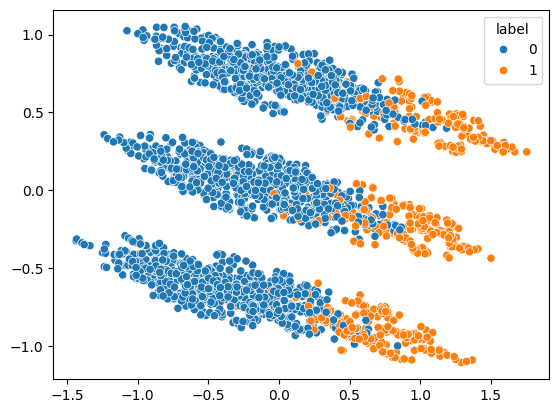

In [387]:
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=train_df_level_1['label']);

## t-SNE

In [388]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(train_df_level_1.drop('label', axis=1))

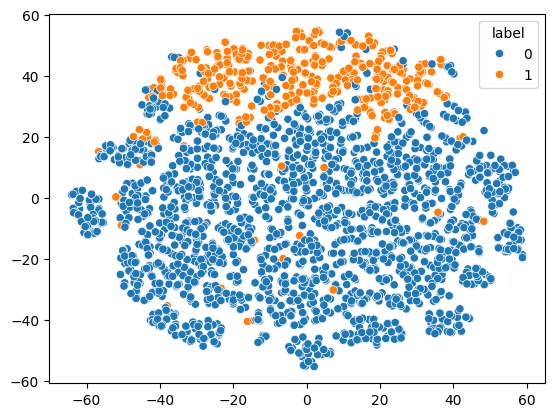

In [389]:
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=train_df_level_1['label']);

## MDS

In [390]:
mds = MDS(n_components=2, n_init=2, init='random')

In [391]:
mds_result = mds.fit_transform(train_df_level_1.drop('label', axis=1))

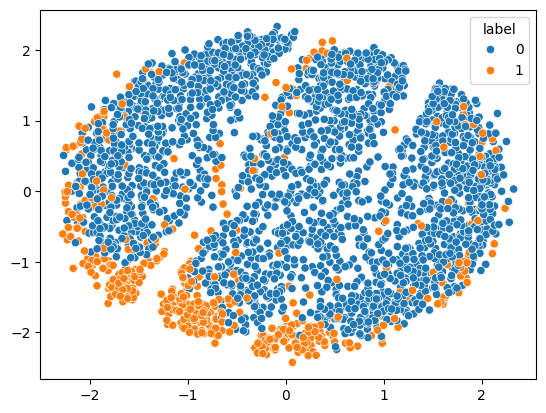

In [392]:
sns.scatterplot(x=mds_result[:, 0], y=mds_result[:, 1], hue=train_df_level_1['label']);

## Análise

Os gráficos evidenciam que, apesar de grupos distintos não gerarem clusters separados e bem definidos, os casos de alta ansiedade (label 1) ficam sempre próximos uns dos outros, além de não haver alta sobreposição entre instâncias de grupos distintos.

# KNN ($k$-*Nearest Neighbors*)

In [393]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

## Nível 1

Nessa seção será avaliado o desempenho do KNN para as categorias no nível um (muito ansioso e pouco ansioso).

In [394]:
train_df_level_1 = pd.read_csv('train_data/train_level_1.csv')
X_1_train = train_df_level_1.drop('label', axis=1)
y_1_train = train_df_level_1['label']

test_df_level_1 = pd.read_csv('test_data/test_level_1.csv')
X_1_test = test_df_level_1.drop('label', axis=1)
y_1_test = test_df_level_1['label']

In [395]:
params = {'n_neighbors': list(range(1, 42, 2))}

In [396]:
clf = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf.fit(X_1_train, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 37


In [397]:
y_pred = clf.predict(X_1_test)
print(classification_report(y_1_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       701
           1       0.99      0.98      0.98       161

    accuracy                           0.99       862
   macro avg       0.99      0.99      0.99       862
weighted avg       0.99      0.99      0.99       862



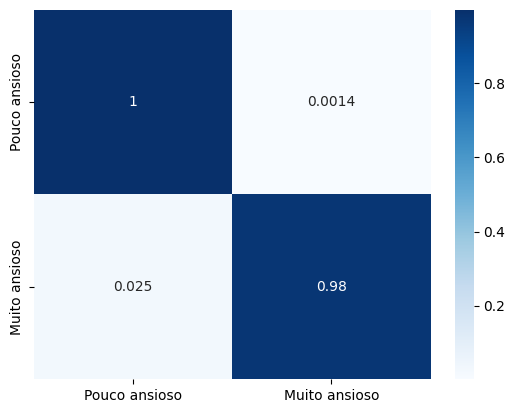

In [398]:
sns.heatmap(confusion_matrix(y_1_test, y_pred, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É possível perceber que o desempenho do algoritmo foi excelente, tendo valores de acurácia, precisão e recall próximos de 100%.

### PCA

In [399]:
pca = PCA(n_components=3)
X_1_train_2d = pca.fit_transform(X_1_train)
clf.fit(X_1_train_2d, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 1


In [400]:
X_1_test_2d = pca.transform(X_1_test)
y_pred_2d = clf.predict(X_1_test_2d)
print(classification_report(y_1_test, y_pred_2d))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       701
           1       0.97      0.96      0.97       161

    accuracy                           0.99       862
   macro avg       0.98      0.98      0.98       862
weighted avg       0.99      0.99      0.99       862



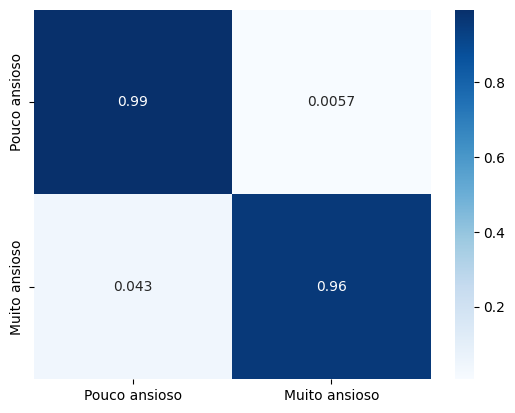

In [401]:
sns.heatmap(confusion_matrix(y_1_test, y_pred_2d, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É possível notar que, mesmo com apenas três dimensões, os resultados foram excelentes.

Obs.: é interessante perceber que o *grid search* achou $k = 1$ como melhor parâmetro.

### Testando com a remoção de features irrelevantes

In [402]:
aux = [
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]

irrelevant_cols = list()
for df_col in train_df_level_1.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)
irrelevant_cols

['Smoking_Yes',
 'Dizziness_Yes',
 'Medication_Yes',
 'Recent Major Life Event_Yes',
 'Gender_Male',
 'Gender_Other',
 'Occupation_Athlete',
 'Occupation_Chef',
 'Occupation_Doctor',
 'Occupation_Engineer',
 'Occupation_Freelancer',
 'Occupation_Lawyer',
 'Occupation_Musician',
 'Occupation_Nurse',
 'Occupation_Other',
 'Occupation_Scientist',
 'Occupation_Student',
 'Occupation_Teacher']

In [404]:
X_1_train_no_irrelevant = train_df_level_1.drop(columns=irrelevant_cols + ['label'])
clf.fit(X_1_train_no_irrelevant, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 3


In [406]:
y_pred_no_irrelevant = clf.predict(test_df_level_1.drop(columns=irrelevant_cols + ['label']))
print(classification_report(y_1_test, y_pred_no_irrelevant))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       0.99      1.00      0.99       161

    accuracy                           1.00       862
   macro avg       0.99      1.00      1.00       862
weighted avg       1.00      1.00      1.00       862



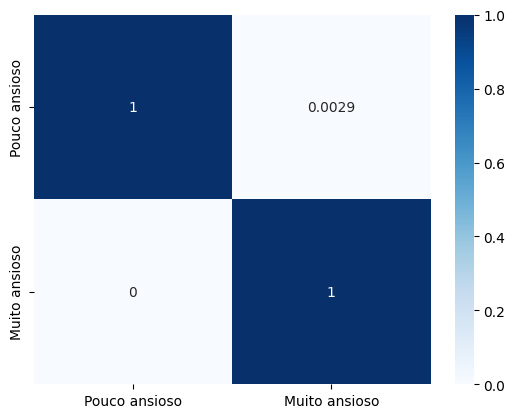

In [407]:
sns.heatmap(confusion_matrix(y_1_test, y_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É interessante notar que, apesar de não ser usual, ao remover as features de baixa relevância as métricas de desempenho se mostraram superiores.

## Nível 2

Nessa seção será avaliado o desempenho do KNN para o nível 2 (pouco/médio ansioso vs médio/muito ansioso).

In [408]:
train_df_level_2 = pd.read_csv('train_data/train_level_2.csv')
X_2_train = train_df_level_2.drop('label', axis=1)
y_2_train = train_df_level_2['label']

test_df_level_2 = pd.read_csv('test_data/test_level_2.csv')
X_2_test = test_df_level_2.drop('label', axis=1)
y_2_test = test_df_level_2['label']

In [409]:
params = {'n_neighbors': list(range(1, 42, 2))}

In [410]:
clf2 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf2.fit(X_2_train, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 35


In [411]:
y2_pred = clf2.predict(X_2_test)
print(classification_report(y_2_test, y2_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2293
           1       0.97      0.39      0.56       457

    accuracy                           0.90      2750
   macro avg       0.93      0.69      0.75      2750
weighted avg       0.91      0.90      0.88      2750



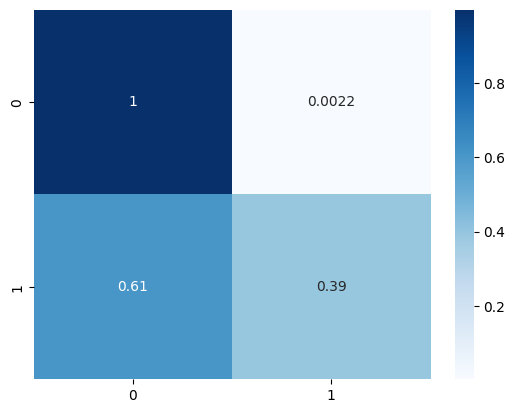

In [412]:
sns.heatmap(confusion_matrix(y_2_test, y2_pred, normalize='true'), annot=True, cmap='Blues');

### PCA

In [413]:
pca = PCA(n_components=3)
X_2_train_2d = pca.fit_transform(X_2_train)
clf2.fit(X_2_train_2d, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 5


In [414]:
X_2_test_2d = pca.transform(X_2_test)
y2_pred_2d = clf2.predict(X_2_test_2d)
print(classification_report(y_2_test, y2_pred_2d))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2293
           1       0.89      0.54      0.67       457

    accuracy                           0.91      2750
   macro avg       0.90      0.76      0.81      2750
weighted avg       0.91      0.91      0.90      2750



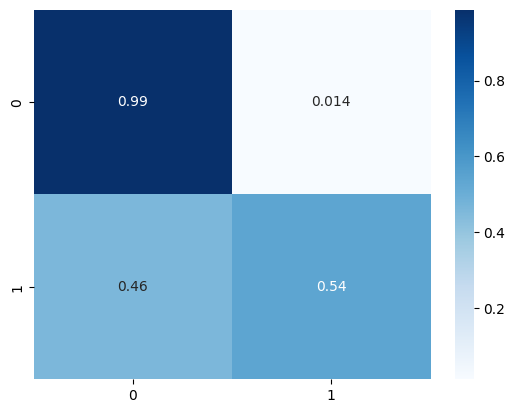

In [415]:
sns.heatmap(confusion_matrix(y_2_test, y2_pred_2d, normalize='true'), annot=True, cmap='Blues');

### Testando com a remoção de features irrelevantes

In [416]:
X_2_train_no_irrelevant = train_df_level_2.drop(columns=irrelevant_cols + ['label'])
clf2.fit(X_2_train_no_irrelevant, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 33


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2293
           1       0.95      0.60      0.74       457

    accuracy                           0.93      2750
   macro avg       0.94      0.80      0.85      2750
weighted avg       0.93      0.93      0.92      2750



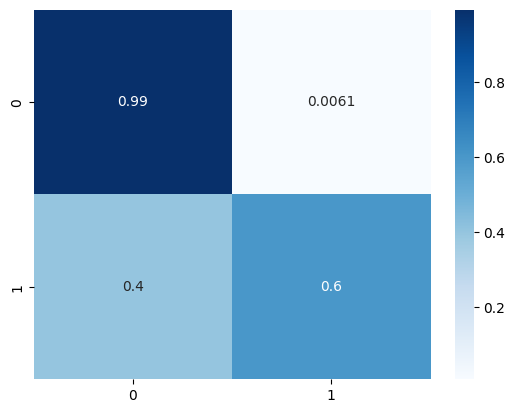

In [417]:
y2_pred_no_irrelevant = clf2.predict(test_df_level_2.drop(columns=irrelevant_cols + ['label']))
print(classification_report(y_2_test, y2_pred_no_irrelevant))
sns.heatmap(confusion_matrix(y_2_test, y2_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues');

## Nível 3

Nessa seção será avaliado o desempenho do KNN para o nível 3 (três classes: pouco, moderada, muito).

In [418]:
train_df_level_3 = pd.read_csv('train_data/train_level_3.csv')
X_3_train = train_df_level_3.drop('label', axis=1)
y_3_train = train_df_level_3['label']
test_df_level_3 = pd.read_csv('test_data/test_level_3.csv')
X_3_test = test_df_level_3.drop('label', axis=1)
y_3_test = test_df_level_3['label']

In [419]:
params = {'n_neighbors': list(range(1, 42, 2))}

In [420]:
clf3 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf3.fit(X_3_train, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [421]:
y3_pred = clf3.predict(X_3_test)
print(classification_report(y_3_test, y3_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.48      0.61       706
         1.0       0.72      0.94      0.81      1160
         2.0       0.99      0.58      0.73       161

    accuracy                           0.75      2027
   macro avg       0.85      0.67      0.72      2027
weighted avg       0.78      0.75      0.74      2027



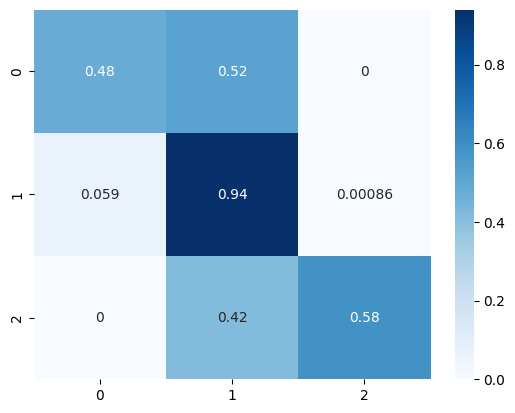

In [422]:
sns.heatmap(confusion_matrix(y_3_test, y3_pred, normalize='true'), annot=True, cmap='Blues');

### PCA (nível 3)

In [423]:
pca = PCA(n_components=3)
X_3_train_2d = pca.fit_transform(X_3_train)
clf3.fit(X_3_train_2d, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 7


In [424]:
X_3_test_2d = pca.transform(X_3_test)
y3_pred_2d = clf3.predict(X_3_test_2d)
print(classification_report(y_3_test, y3_pred_2d))

              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60       706
         1.0       0.73      0.81      0.77      1160
         2.0       0.95      0.76      0.84       161

    accuracy                           0.72      2027
   macro avg       0.77      0.71      0.74      2027
weighted avg       0.72      0.72      0.71      2027



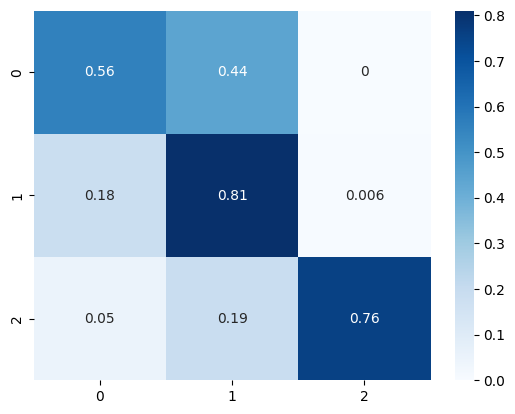

In [425]:
sns.heatmap(confusion_matrix(y_3_test, y3_pred_2d, normalize='true'), annot=True, cmap='Blues');

### Testando com a remoção de features irrelevantes (nível 3)

In [426]:
X_3_train_no_irrelevant = train_df_level_3.drop(columns=irrelevant_cols + ['label'])
clf3.fit(X_3_train_no_irrelevant, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 21


              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       706
         1.0       0.86      0.87      0.87      1160
         2.0       0.95      1.00      0.97       161

    accuracy                           0.85      2027
   macro avg       0.87      0.88      0.87      2027
weighted avg       0.85      0.85      0.85      2027



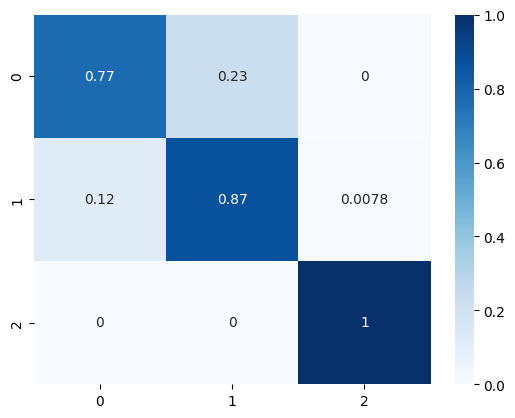

In [427]:
y3_pred_no_irrelevant = clf3.predict(test_df_level_3.drop(columns=irrelevant_cols + ['label']))
print(classification_report(y_3_test, y3_pred_no_irrelevant))
sns.heatmap(confusion_matrix(y_3_test, y3_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues');

## Nível 4

Nessa seção será avaliado o desempenho do KNN usando as categorias originais (níveis 1–10).

In [428]:
train_df_level_4 = pd.read_csv('train_data/train_level_4.csv')
X_4_train = train_df_level_4.drop('label', axis=1)
y_4_train = train_df_level_4['label']
test_df_level_4 = pd.read_csv('test_data/test_level_4.csv')
X_4_test = test_df_level_4.drop('label', axis=1)
y_4_test = test_df_level_4['label']

In [429]:
params = {'n_neighbors': list(range(1, 42, 2))}

In [430]:
clf4 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf4.fit(X_4_train, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [431]:
y4_pred = clf4.predict(X_4_test)
print(classification_report(y_4_test, y4_pred, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.36      0.08      0.13       250
         2.0       0.33      0.22      0.26       450
         3.0       0.25      0.42      0.31       589
         4.0       0.25      0.42      0.31       584
         5.0       0.25      0.13      0.17       420
         6.0       0.00      0.00      0.00       155
         7.0       0.00      0.00      0.00        31
         8.0       0.32      0.28      0.30        95
         9.0       0.22      0.11      0.15        98
        10.0       0.33      0.19      0.24        78

    accuracy                           0.26      2750
   macro avg       0.23      0.19      0.19      2750
weighted avg       0.26      0.26      0.24      2750



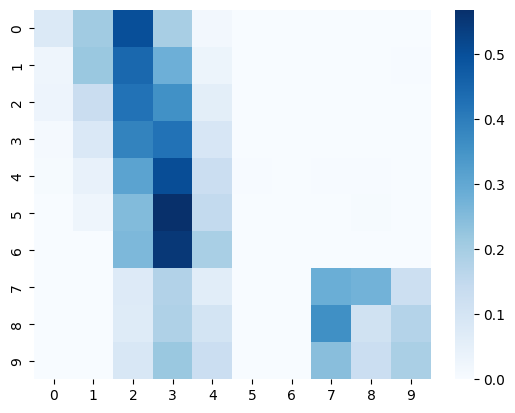

In [432]:
sns.heatmap(confusion_matrix(y_4_test, y4_pred, normalize='true'), cmap='Blues');

### PCA

In [433]:
pca = PCA(n_components=3)
X_4_train_2d = pca.fit_transform(X_4_train)
clf4.fit(X_4_train_2d, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [434]:
X_4_test_2d = pca.transform(X_4_test)
y4_pred_2d = clf4.predict(X_4_test_2d)
print(classification_report(y_4_test, y4_pred_2d, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.22      0.05      0.08       250
         2.0       0.28      0.21      0.24       450
         3.0       0.23      0.39      0.29       589
         4.0       0.25      0.41      0.31       584
         5.0       0.28      0.16      0.20       420
         6.0       0.00      0.00      0.00       155
         7.0       0.00      0.00      0.00        31
         8.0       0.36      0.26      0.30        95
         9.0       0.30      0.14      0.19        98
        10.0       0.22      0.09      0.13        78

    accuracy                           0.25      2750
   macro avg       0.21      0.17      0.17      2750
weighted avg       0.24      0.25      0.23      2750



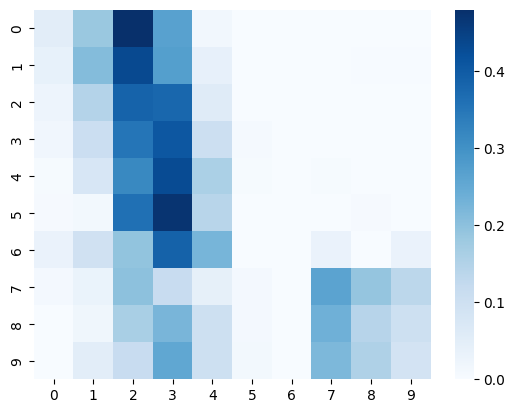

In [435]:
sns.heatmap(confusion_matrix(y_4_test, y4_pred_2d, normalize='true'), cmap='Blues');

### Testando com a remoção de features irrelevantes

In [436]:
X_4_train_no_irrelevant = train_df_level_4.drop(columns=irrelevant_cols + ['label'])
clf4.fit(X_4_train_no_irrelevant, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


              precision    recall  f1-score   support

         1.0       0.40      0.20      0.27       250
         2.0       0.35      0.32      0.33       450
         3.0       0.30      0.40      0.34       589
         4.0       0.33      0.46      0.38       584
         5.0       0.35      0.27      0.30       420
         6.0       0.42      0.03      0.06       155
         7.0       0.00      0.00      0.00        31
         8.0       0.29      0.38      0.33        95
         9.0       0.33      0.23      0.28        98
        10.0       0.28      0.31      0.29        78

    accuracy                           0.33      2750
   macro avg       0.31      0.26      0.26      2750
weighted avg       0.34      0.33      0.31      2750



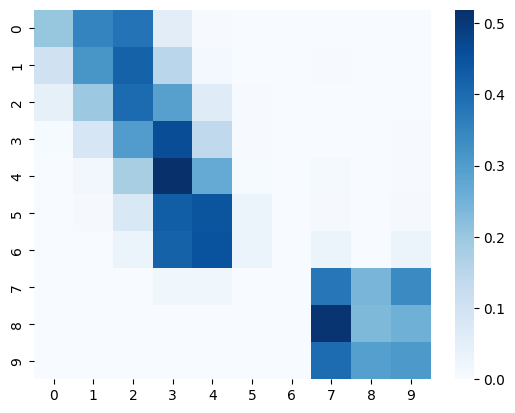

In [437]:
y4_pred_no_irrelevant = clf4.predict(test_df_level_4.drop(columns=irrelevant_cols + ['label']))
print(classification_report(y_4_test, y4_pred_no_irrelevant, zero_division=0))
sns.heatmap(confusion_matrix(y_4_test, y4_pred_no_irrelevant, normalize='true'), cmap='Blues');